<a href="https://colab.research.google.com/github/ealeongomez/Machine-Learning/blob/main/LR_Nested_Cross_Validation_Gaussian_Procces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/ealeongomez/Data

Cloning into 'Data'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 35 (delta 8), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (35/35), done.


In [ ]:
cd Data/

/content/Data


In [ ]:
ls

datasets_730942_1268848_sarcasmo.tsv  MK30.csv           time_machine.txt
jena_climate_2009_2016.csv.zip        PuertoBolivar.csv


In [ ]:
# Basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.pipeline import Pipeline
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

# Métricas de rendimiento
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score

from scipy.stats import mode

#**Load data**

In [ ]:
data = pd.read_csv('MK30.csv')['Values']
dataset = np.array(data)[0:180]

train_set = dataset[0:120]           # Training data
test_set  = dataset[150:180]         # Testing data
time_delay = 6                       # Time delay (embedding length)
N_tr = 100                           # Number of training samples
N_te = 20                            # Number of testing samples
horizon = 1                          # Prediction horizon 
time = np.arange(0, len(dataset),1)


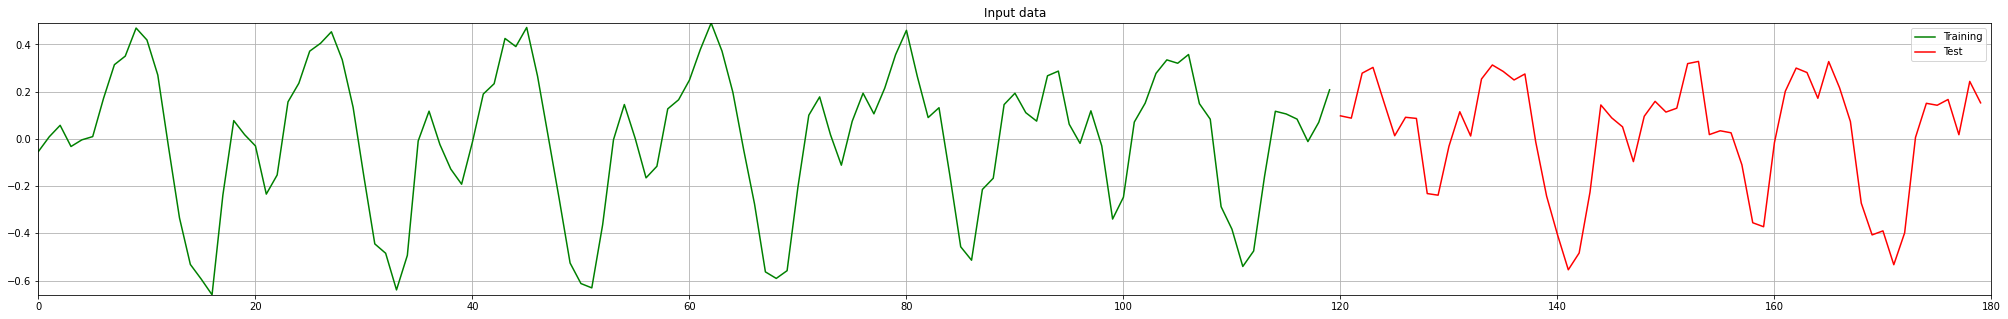

In [ ]:
plt.figure(figsize=(35, 5))

plt.plot(time[0:len(train_set)], dataset[0:len(train_set)], 'g', label= 'Training')
plt.plot(time[len(train_set):], dataset[len(train_set):], 'r', label= 'Test')
plt.xlim(0,len(dataset))
plt.ylim(min(dataset), max(dataset))
plt.title("Input data")
plt.legend()
plt.grid()
plt.show()

In [ ]:
X = np.zeros([N_tr, time_delay])
for i in range(N_tr):
    X[i,:] = train_set[i:i+time_delay+horizon-1]
y = train_set[time_delay:time_delay+N_tr+horizon-1]

X_test = np.zeros([N_te, time_delay])
for i in range(N_te):
    X_test[i,:] = test_set[i:i+time_delay+horizon-1]
y_test = test_set[time_delay:time_delay+N_te+horizon-1]

X.shape, y.shape, X_test.shape, y_test.shape


((100, 6), (100,), (20, 6), (20,))

#**Linear Regression**


*   Kernel Ridge Regressor [1]
*   Gaussian procces Regressor [2]


Papers:
    
  [1] https://www.ics.uci.edu/~welling/classnotes/papers_class/Kernel-Ridge.pdf
  
  [2] https://www.sciencedirect.com/science/article/abs/pii/S0022249617302158

#**Nested-Cross-Validation** 


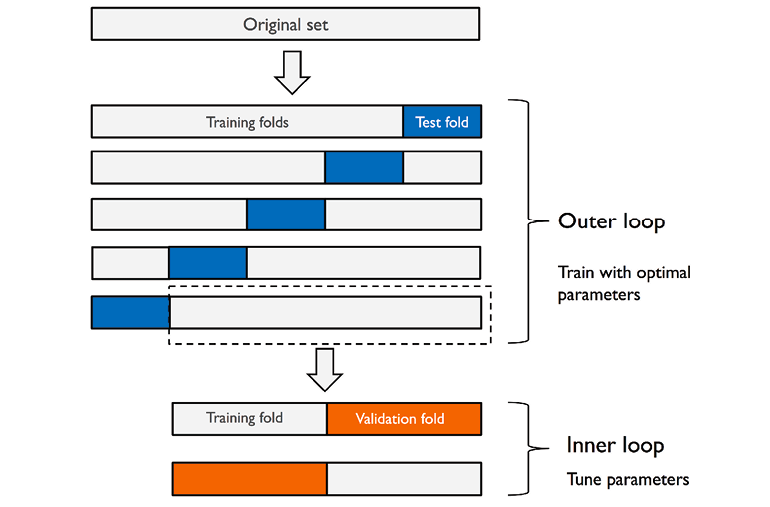

#**Machine Learning**

Kernel RBF de Gaussian Process

$$k(x_i, x_j) = C * exp \left( -\frac{d(x_i,x_j)}{2l^2} \right) $$

Donde $d(x_i,x_j)$ es la disancia euclidea y $l$ es la escala del kernel



In [ ]:
# Construcción del esquema de predicción
steps = [('scaler', StandardScaler()), 
         ('reg', GaussianProcessRegressor())]

# Kernel parameters
sigma_f = 2
sigma_n = 0.4

kernels = [RBF(length_scale=0.001, length_scale_bounds=(1e-2, 1e2)),
           RBF(length_scale=0.01, length_scale_bounds=(1e-2, 1e2)), 
           RBF(length_scale=0.1, length_scale_bounds=(1e-2, 1e2)), 
           RBF(length_scale=1, length_scale_bounds=(1e-2, 1e2)),
           RBF(length_scale=10, length_scale_bounds=(1e-2, 1e2)), 
           RBF(length_scale=100, length_scale_bounds=(1e-2, 1e2)), 
           RBF(length_scale=1000, length_scale_bounds=(1e-2, 1e2))]

param_grid = {'reg__alpha':[1e-3, 1e-2, 1e-1, 1, 10], 
              'reg__kernel':kernels}

pipeline = Pipeline(steps=steps)              


In [ ]:
# Número particiones Outter loop nested cross-validation
Niter = 10                                                                      

# Arreglo para guardar acierto
msev =np.zeros(Niter)         

# Lista lazo interno para guardar mejor estimador por modelo para iteracion j
list_est = []   

# Lista lazo interno para guardar mejores hyperparametros por modelo para iteracion j                                                                  
list_hyper = [] 

# Bucle externo
for j in range(Niter):   
  X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3) 

  grid_search = GridSearchCV(pipeline,
                             param_grid,
                             n_jobs=-1,
                             cv=5,
                             scoring='neg_mean_squared_error',
                             verbose=0)
  
  # Generar el modelo
  grid_search.fit(X_train, y_train)

  # Estimar salida para el conjunto de test
  forecasting = grid_search.best_estimator_.predict(X_valid)

  # Guardar mejor modelo
  list_est.append(grid_search.best_estimator_)
  list_hyper.append(grid_search.best_params_)

  # Guardar métrica
  msev[j] = "{0:.2f}".format(mean_squared_error(y_valid, forecasting))


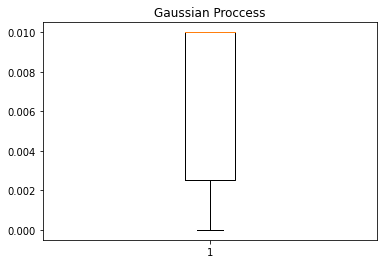

[0.01 0.   0.01 0.01 0.   0.01 0.01 0.01 0.01 0.  ]


In [ ]:
plt.boxplot(msev)
plt.title("Gaussian Proccess")
plt.show()

print(msev)

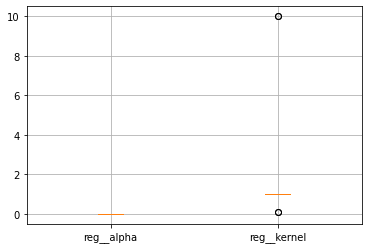

Mejores hiperparametros =  [0.001 1.   ]


In [ ]:
# Mejores hiperpametros
nh = len(list_hyper[0])
hyperparameters = np.zeros((Niter, nh))

for i in range(Niter):
  for j in range(nh): 
    
    if j == 0:
      hyperparameters[i,j] = list_hyper[i].get(list(list_hyper[i].keys())[j])
    else:
      hyperparameters[i,j] = list_hyper[i].get(list(list_hyper[i].keys())[j]).length_scale


plt.boxplot(hyperparameters)

plt.xticks(ticks=np.arange(nh)+1,labels=list(list_hyper[i].keys()))

plt.grid()
plt.show()

# Mejores hiperparametros 
mode_hyper = mode(hyperparameters, axis=0)[0][0]

print("Mejores hiperparametros = ", mode_hyper)

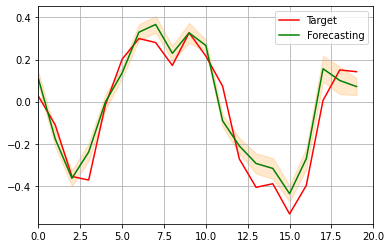

In [ ]:
# Entrenar con los mejores modelos 
model_GP = Pipeline(steps) 

parameter_GP = {'reg__alpha': 0.001, 'reg__kernel': RBF(length_scale=1)}

model_GP.set_params(**parameter_GP)

model_GP.fit(X, y)

forecasting, y_std = model_GP.predict(X_test, return_std=True)

plt.plot(y_test, 'r', label='Target')
plt.plot(forecasting, 'g', label='Forecasting')
plt.fill_between(np.arange(0,len(y_test),1), np.squeeze(forecasting)-y_std, np.squeeze(forecasting)+y_std, color='darkorange', alpha=0.2)
plt.xlim(0,len(y_test))
plt.legend()
plt.grid()
plt.show()

In [ ]:
print("Mean Square Error (MSE): {}".format(mean_squared_error(y_test, forecasting, squared=False)))
print("Root Mean Square Error (MSE): {}".format(mean_squared_error(y_test, forecasting, squared=True)))
print("Mean Absolute Error (MAE): {}".format(mean_absolute_error(y_test, forecasting)))
print("R2: {}".format(r2_score(y_test, forecasting)))

Mean Square Error (MSE): 0.08716952545637763
Root Mean Square Error (MSE): 0.007598526168290068
Mean Absolute Error (MAE): 0.07501018282952782
R2: 0.8991322270131044
